
# Vocal separation

This notebook demonstrates a simple technique for separating vocals (and
other sporadic foreground signals) from accompanying instrumentation.

<div class="alert alert-danger"><h4>Warning</h4><p>This example is primarily of historical interest, and we do not recommend
    this as a competitive method for vocal source separation.
    For a more recent treatment of vocal and music source separation, please
    refer to [Open Source Tools & Data for Music Source Separation](https://source-separation.github.io/tutorial/landing.html) [1]_.</p></div>

This is based on the "REPET-SIM" method of [Rafii and Pardo, 2012](http://www.cs.northwestern.edu/~zra446/doc/Rafii-Pardo%20-%20Music-Voice%20Separation%20using%20the%20Similarity%20Matrix%20-%20ISMIR%202012.pdf)
[2]_, but includes a couple of modifications and extensions:

    - FFT windows overlap by 1/4, instead of 1/2
    - Non-local filtering is converted into a soft mask by Wiener filtering.
      This is similar in spirit to the soft-masking method used by [Fitzgerald, 2012](http://arrow.dit.ie/cgi/viewcontent.cgi?article=1086&context=argcon)
      [3]_,
      but is a bit more numerically stable in practice.

.. [1] Manilow, Ethan, Prem Seetharman, and Justin Salamon.
    "Open source tools & data for music source separation."
    2020.

.. [2] Rafii, Zafar, and Bryan Pardo.
    "Music/Voice Separation Using the Similarity Matrix."
    In ISMIR, pp. 583-588. 2012.

.. [3] FitzGerald, Derry.
    "Vocal separation using nearest neighbours and median filtering."
    23rd IET Irish Signals and Systems Conference, Maynooth.  (2012): 98-98.


In [1]:
# Code source: Brian McFee
# License: ISC

##################
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa

Load an example with vocals.



In [8]:
# Define a class to load our own custom songs

class AudioSample:
    def __init__(self, name, path, start_sec, end_sec, duration=120):
        self.name = name
        self.path = path
        self.duration = duration
        self.y = None
        self.sr = None
        self.S_full = None
        self.phase = None
        self.start_sec = start_sec
        self.end_sec = end_sec

    def load(self):
        self.y, self.sr = librosa.load(self.path, duration=self.duration)
        self.S_full, self.phase = librosa.magphase(librosa.stft(self.y))

    def play(self, start_sec, end_sec):
        if self.y is not None and self.sr is not None:
            return Audio(data=self.y[start_sec*self.sr:end_sec*self.sr], rate=self.sr)
        else:
            print("Audio not loaded. Call load() first.")
            return None

# Define your samples
samples = {
    "MedleyDB_sample": AudioSample("MedleyDB_sample", '/media/allentao/One Touch/APS360/MedleyDB_sample/Audio/Phoenix_ScotchMorris/Phoenix_ScotchMorris_MIX.wav', 10, 15),
    "MedleyDB_V2": AudioSample("MedleyDB_V2", '/media/allentao/One Touch/APS360/MedleyDB_V2/V2/BarefootSisters_RedJetta/BarefootSisters_RedJetta_MIX.wav', 15, 20)
}

# Load and play all samples
for sample_name, sample in samples.items():
    print(f"Loading and playing sample: {sample_name}")
    sample.load()
    audio = sample.play(sample.start_sec, sample.end_sec)
    display(audio)

Loading and playing sample: MedleyDB_sample


Loading and playing sample: MedleyDB_V2


Choose which piece you want to run extraction on

In [9]:
S_full, phase = librosa.magphase(librosa.stft(samples["MedleyDB_V2"].y))
y, sr = librosa.load(samples["MedleyDB_V2"].path, duration=120)
start_sec, end_sec = samples["MedleyDB_V2"].start_sec, samples["MedleyDB_V2"].end_sec

In [ ]:
# # If you want to load the default example from the docs
# # otherwise don't run this cell
# y, sr = librosa.load(librosa.ex('fishin'), duration=120)

# # MedleyDB_sample: non vocal example, results are very scratchy but not bad
# #y, sr = librosa.load('/media/allentao/One Touch/APS360/MedleyDB_sample/Audio/Phoenix_ScotchMorris/Phoenix_ScotchMorris_MIX.wav', duration=120)

# # MedleyDB_V2 sample: vocal example: does a pretty good job getting the voiceline
# # background music has some sound signatures from the melody
# # y, sr = librosa.load('/media/allentao/One Touch/APS360/MedleyDB_V2/V2/BarefootSisters_RedJetta/BarefootSisters_RedJetta_MIX.wav', duration=120)



# # And compute the spectrogram magnitude and phase
# S_full, phase = librosa.magphase(librosa.stft(y))

# # Play back a 5-second excerpt with vocals

# Audio(data=y[10*sr:15*sr], rate=sr)
# # Audio(data=y[10*sr:15*sr], rate=sr)
# # Audio(data=y[15*sr:20*sr], rate=sr)

Plot a 5-second slice of the spectrum



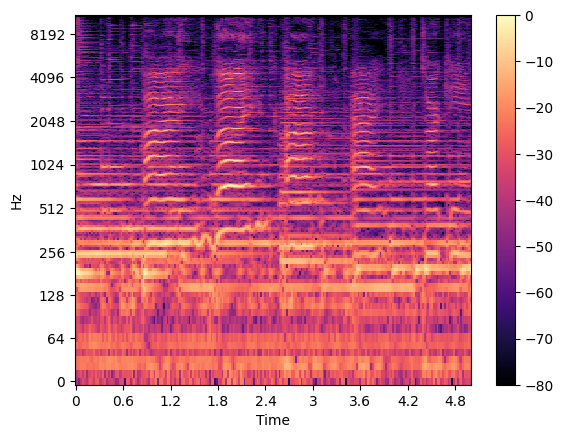

In [10]:
idx = slice(*librosa.time_to_frames([start_sec, end_sec], sr=sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

The wiggly lines above are due to the vocal component.
Our goal is to separate them from the accompanying
instrumentation.




In [11]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimum
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

The raw filter output can be used as a mask,
but it sounds better if we use soft-masking.



In [12]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

Plot the same slice, but separated into its foreground and background



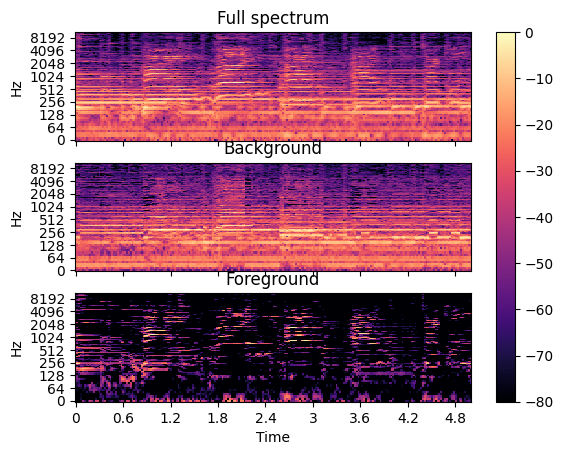

In [13]:
# sphinx_gallery_thumbnail_number = 2

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].set(title='Full spectrum')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title='Background')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[2])
ax[2].set(title='Foreground')
fig.colorbar(img, ax=ax)

Recover the foreground audio from the masked spectrogram.
To do this, we'll need to re-introduce the phase information
that we had previously set aside.



In [14]:
y_foreground = librosa.istft(S_foreground * phase)
# Play back a 5-second excerpt with vocals
Audio(data=y_foreground[15*sr:20*sr], rate=sr)

Attempt to generate an accompaniment track from the background

In [15]:
# generate background audio
y_background = librosa.istft(S_background * phase)
# Play back a 5-second excerpt with vocals
Audio(data=y_background[15*sr:20*sr], rate=sr)

Now, convert both the extracted melody and accompaniment into piano MIDI

In [24]:
import pretty_midi

def audio_to_midi(y, sr, filename):
    # Extract the pitch using librosa's piptrack function
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)

    # Create a PrettyMIDI object
    midi = pretty_midi.PrettyMIDI()

    # Create an Instrument instance for a piano (MIDI program 0)
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)

    # Iterate over all time frames
    for t in range(pitches.shape[1]):
        # Find the frequency bin with the highest magnitude in this time frame
        index = magnitudes[:, t].argmax()
        pitch = pitches[index, t]

        # If the magnitude is low, assume it's silence
        if magnitudes[index, t] < 1.0:
            continue

        # Convert frequency to MIDI note
        midi_note = pretty_midi.hz_to_note_number(pitch)

        # Create a Note instance for this MIDI note
        note = pretty_midi.Note(velocity=100, pitch=int(midi_note), start=t/100.0, end=(t+1)/100.0)

        # Add it to our piano instrument
        piano.notes.append(note)

    # Add the piano instrument to the PrettyMIDI object
    midi.instruments.append(piano)

    # Write out the MIDI data
    midi.write(filename)

In [26]:
# Generate foreground and background audio
y_foreground = librosa.istft(S_foreground * phase)
y_background = librosa.istft(S_background * phase)

# Convert the 5-second interval of the foreground and background audio to MIDI
audio_to_midi(y_foreground[15*sr:20*sr], sr, 'foreground.mid')
audio_to_midi(y_background[15*sr:20*sr], sr, 'background.mid')

This is done pretty poorly, let's try Spotify's `basic-pitch`

In [29]:
# First, we need to export the extracted melody and accompaniment audio to audio files 
# that we can pass to Spotify

import soundfile as sf

# Write the foreground and background audio to WAV files
sf.write('foreground.wav', y_foreground[15*sr:20*sr], sr)
sf.write('background.wav', y_background[15*sr:20*sr], sr)

In [47]:
from basic_pitch.inference import predict_and_save
from basic_pitch import ICASSP_2022_MODEL_PATH
import os
import shutil

# make spotify directory
try:
    shutil.rmtree("./spotify/")
except:
    pass
os.makedirs("./spotify/", exist_ok=True)

# Generate MIDI files for foreground.wav and background.wav
predict_and_save(["foreground.wav"], "./spotify/", True, True, False, False)
predict_and_save(["background.wav"], "./spotify/", True, True, False, False)



Predicting MIDI for foreground.wav...


  Creating midi...
  💅 Saved to spotify/foreground_basic_pitch.mid


  Creating midi sonification...
  🎧 Saved to spotify/foreground_basic_pitch.wav

Predicting MIDI for background.wav...


  Creating midi...
  💅 Saved to spotify/background_basic_pitch.mid


  Creating midi sonification...
  🎧 Saved to spotify/background_basic_pitch.wav
